<h1><center> ODABIR ZNAČAJKI </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

In [229]:
# potrebni paketi
import numpy as np
import pandas as pd
import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn as sk
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from functions.draw_histograms_rows_quantile_one_vs_others import *
from functions.draw_histograms_rows_quantile import *
from functions.draw_heatmap import *
from functions.univariate import *
from functions.in_good_range import *

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [230]:
# učitavanje svih značajki iz training skupa
features = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

In [231]:
features.head()

,Id,Class,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,...,visualc,___security_cookie,assume,callvirtualalloc,exportedentry,hardware,hkey_current_user,hkey_local_machine,sp-analysisfailed,unableto
0,01kcPWA9K2BOxQeS5Rju,1,21091,1213,726,817,1257,625,550,523,...,0,0,0,0,0,0,0,0,0,0
1,04EjIdbPV5e1XroFOpiN,1,40030,1980,1226,1193,1971,1096,961,755,...,0,0,0,0,0,0,0,0,0,0
2,05EeG39MTRrI6VY21DPd,1,19419,955,693,656,832,463,370,510,...,0,0,0,0,0,0,0,0,0,0
3,05rJTUWYAKNegBk2wE8X,1,79568,6445,3143,2517,4982,1824,2125,2964,...,0,0,2,0,0,0,0,0,0,0
4,0AnoOZDNbPXIr2MRBSCJ,1,25791,1202,569,750,948,456,405,517,...,0,0,0,0,0,0,0,0,0,0


In [32]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10867 entries, 0 to 10866
Columns: 1695 entries, Id to unableto
dtypes: float64(303), int64(1391), object(1)
memory usage: 140.5+ MB


In [232]:
#ispuštanje id-a malware-a
features.drop(['Id'], axis=1, inplace=True)
features.head()

,Class,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,byte_1G_08,...,visualc,___security_cookie,assume,callvirtualalloc,exportedentry,hardware,hkey_current_user,hkey_local_machine,sp-analysisfailed,unableto
0,1,21091,1213,726,817,1257,625,550,523,1078,...,0,0,0,0,0,0,0,0,0,0
1,1,40030,1980,1226,1193,1971,1096,961,755,2406,...,0,0,0,0,0,0,0,0,0,0
2,1,19419,955,693,656,832,463,370,510,836,...,0,0,0,0,0,0,0,0,0,0
3,1,79568,6445,3143,2517,4982,1824,2125,2964,8301,...,0,0,2,0,0,0,0,0,0,0
4,1,25791,1202,569,750,948,456,405,517,754,...,0,0,0,0,0,0,0,0,0,0


In [138]:
#tražimo značajke s NaN vrijednostima
features_with_null_values = []
for i in range(1486) :
    if features.count()[i] < 10867 :
        #print( i, features.count().index[i], features.count()[i] ) 
        features_with_null_values.append( features.count().index[i] )
        
print( features_with_null_values )

['.text', '.data', '.bss', '.rdata', '.edata', '.idata', '.rsrc', '.tls', '.reloc', 'Num_Sections', 'Unknown_Sections', 'Unknown_Sections_lines', '.text_por', '.data_por', '.rdata_por', 'known_Sections_por', 'Unknown_Sections_por', 'Unknown_Sections_lines_por', 'db_por', 'dd_por', 'dc_por', 'db0_por', 'dbN0_por', 'dd_text', 'dd_rdata', 'db3_rdata', 'db3_data', 'db3_all', 'dd4', 'dd5', 'dd6', 'dd5_all', 'dd5_NdNt', 'db3_all_zero']


Vidimo da se radi o značajkama iz skupine **sekcije** (SEC) i **data define** (DD). Po analizi iz [feature extraction.ipynb](https://github.com/tomarga/Machine-Burning/blob/master/Feature%20extraction.ipynb) bilježnice, znamo da se sve ove značajke odnose na omjer broja određenih linija (SEC) ili omjer korištenja određenih instrukcija (DD) u .asm datoteci. _NaN_ vrijednosti su stoga rezultat dijeljenja $\frac{0}{0}$. Informacija da ne postoji određenih linija ili instrukcija u nekoj sekciji .asm datoteke nam nije beznačajna, tako da na mjesta _NaN_ vrijednosti postavljamo 0.

In [153]:
# NaN -> 0
features.fillna(0, inplace = True)

- izbačeno  0  konstantnih značajki


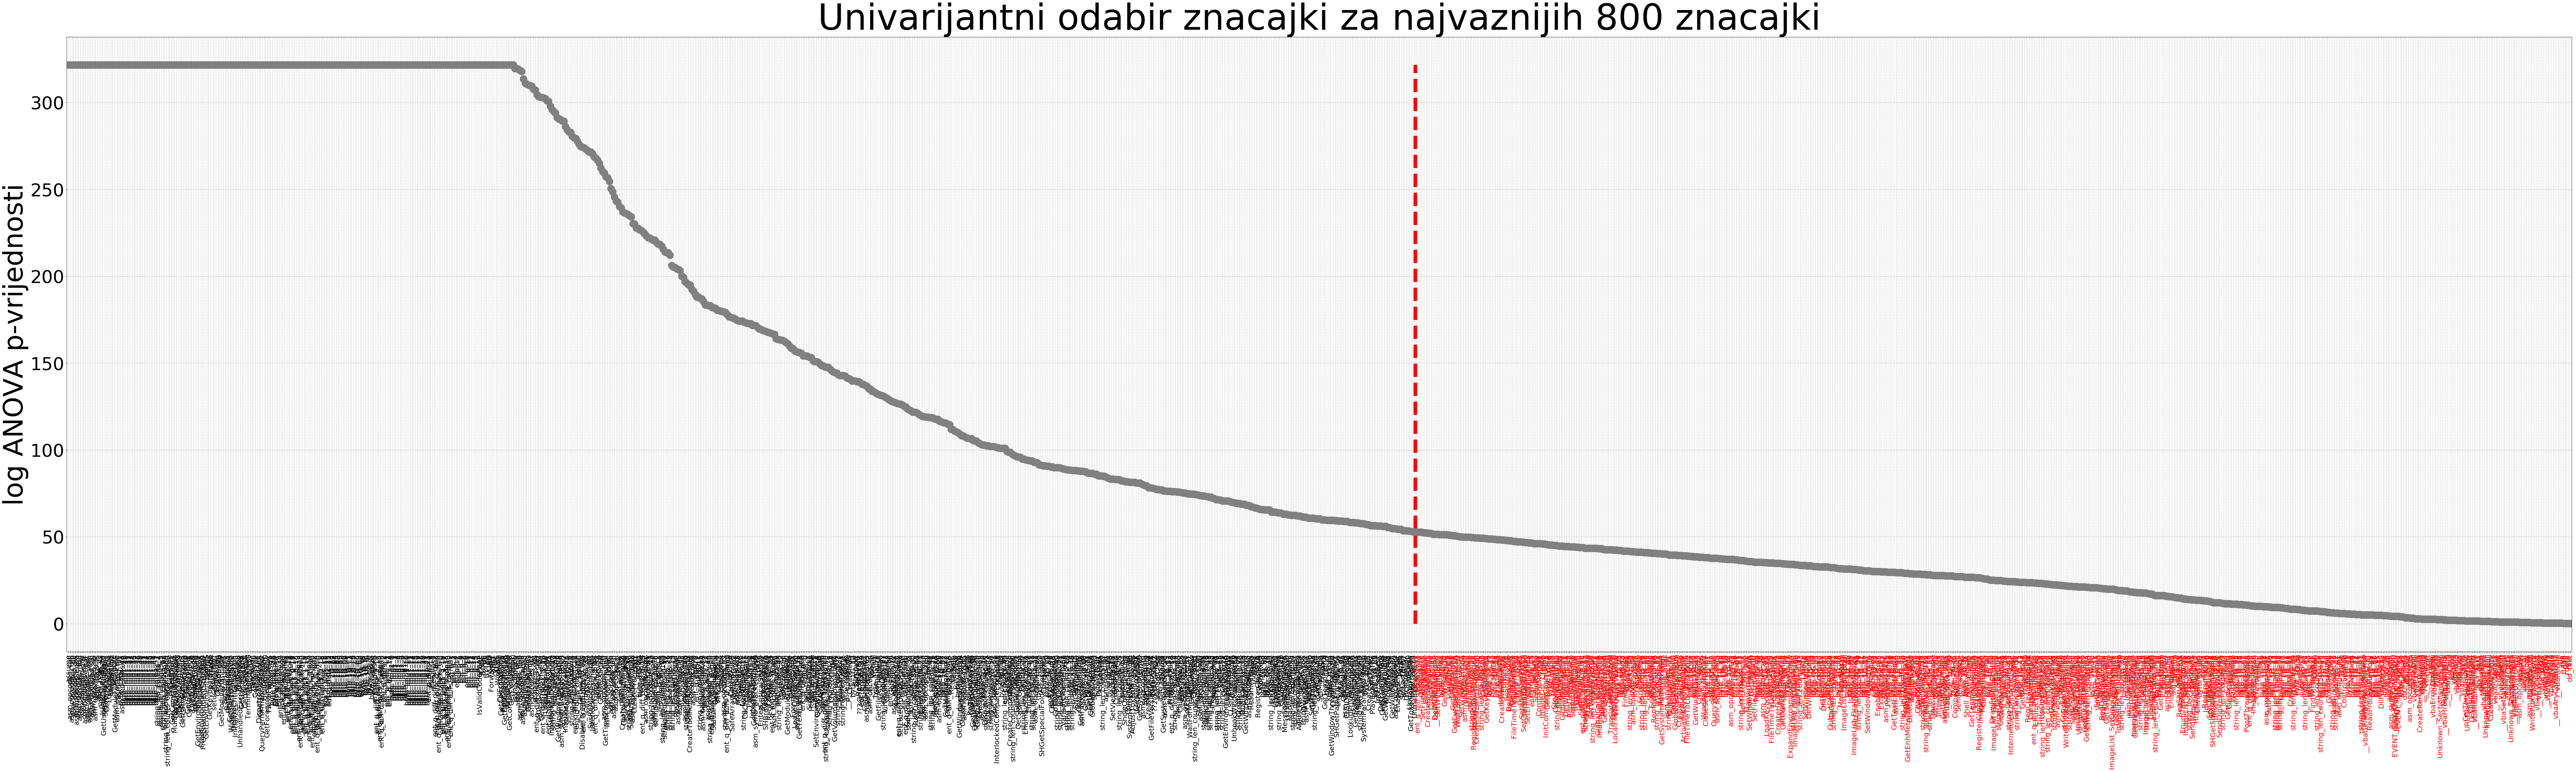

In [161]:
#univarijantna metoda na svim značajkama
with warnings.catch_warnings():
    features_univariate = univariate_plot( features['Class'], features, 800 )

In [167]:
#features_univariate = features[features_univariate.tolist()]
features_univariate.head()

,assume,asm_opcodes_call,asm_opcodes_cmp,asm_opcodes_db,asm_opcodes_dw,asm_opcodes_endp,asm_opcodes_jge,asm_opcodes_jmp,asm_opcodes_jnz,asm_opcodes_jz,...,byte_1G_e6,PatBlt,SetLastError,byte_1G_07,LocalReAlloc,wcslen,UpdateWindow,GetTokenInformation,byte_1G_75,UnmapViewOfFile
0,0,53,15,139,38,14,0,12,11,13,...,358,0,0,523,0,0,0,0,1017,0
1,0,2900,1585,4154,340,732,76,1434,820,1279,...,386,0,0,755,0,123,0,0,2184,0
2,0,461,320,2949,109,235,2,145,170,270,...,296,0,0,510,0,0,0,0,575,0
3,2,10686,7071,20682,504,2214,328,4605,4234,6228,...,883,0,19,2964,0,0,0,6,8719,4
4,0,462,539,3276,81,98,5,240,359,369,...,301,0,5,517,0,0,0,0,767,0


In [170]:
X_train = features_univariate.drop('Class',axis=1)
y_train = features_univariate['Class']

rfecv_rf = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=2),
                 scoring='accuracy')
rfecv_rf.fit(X_train, y_train);

# KASNIJE - PROBATI ZA n_splits = 5

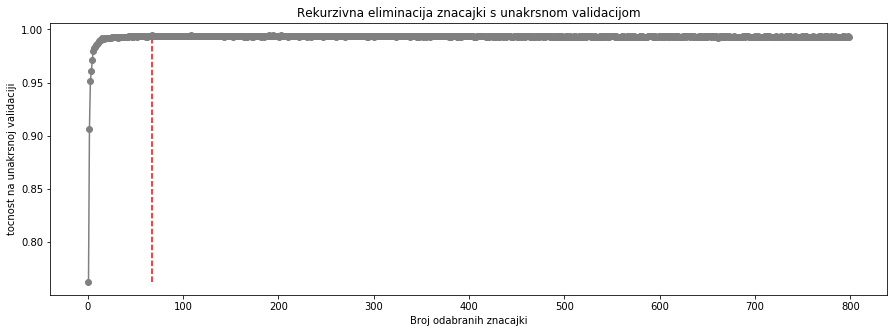

In [179]:
plt.figure(figsize=(15,5))

plt.plot(range(1, len(rfecv_rf.grid_scores_) + 1), rfecv_rf.grid_scores_, '-o',color='gray')
plt.xlabel('Broj odabranih znacajki')
plt.ylabel('tocnost na unakrsnoj validaciji')
plt.title('Rekurzivna eliminacija znacajki s unakrsnom validacijom')
plt.vlines(rfecv_rf.n_features_, 
           np.min(rfecv_rf.grid_scores_), 
           rfecv_rf.grid_scores_[rfecv_rf.n_features_-1], 
           color='red', linestyle='--')
plt.show()

In [173]:
rfecv_rf.n_features_

68

In [233]:
print('Odabrane znacajke s RFECV (koristeci slucajne sume):')
for i in list(features_univariate.columns.values[:-1][rfecv_rf.get_support()]):
    print(' - ' + i )

Odabrane znacajke s RFECV (koristeci slucajne sume):
 - asm_opcodes_jnz
 - GetProcAddress
 - LoadLibraryA
 - ExitProcess
 - VirtualAlloc
 - asm_md_filesize
 - byte_Img1_38
 - byte_Img1_41
 - string_len_counts_2
 - LCMapStringA
 - GetStringTypeA
 - GetEnvironmentStrings
 - _XcptFilter
 - _controlfp
 - exit
 - UnhandledExceptionFilter
 - ent_q_diffs_19
 - ent_q_diffs_var
 - ent_q_diffs_max
 - ent_q_diff_diffs_1_median
 - ent_q_diff_diffs_1_min
 - byte_filesize
 - byte_offset
 - ent_q_diff_diffs_2_median
 - byte_Img1_1
 - byte_Img1_11
 - byte_Img1_12
 - byte_Img1_15
 - ent_p_19
 - ent_p_18
 - ent_p_3
 - ent_q_diff_diffs_2_min
 - ent_p_4
 - ent_p_17
 - ent_p_5
 - ent_p_6
 - ent_p_16
 - BOOL
 - db
 - Forwarder
 - Offset
 - ent_p_diffs_9
 - asm_opcodes_rcr
 - ent_q_diff_diffs_3_var
 - asm_regs_eax
 - asm_symb_Bracket_Open
 - InterlockedExchange
 - GetMessageA
 - string_total_len
 - GetDesktopWindow
 - CreateWindowExA
 - ent_q_diff_diffs_0_max-min
 - FindFirstFileA
 - ent_q_diffs_min
 - ent_p

In [203]:
selected_features = features_univariate[list( features_univariate.columns.values[:-1][rfecv_rf.get_support()] )]
selected_features.head()

,asm_opcodes_jnz,GetProcAddress,LoadLibraryA,ExitProcess,VirtualAlloc,asm_md_filesize,byte_Img1_38,byte_Img1_41,string_len_counts_2,LCMapStringA,...,asm_opcodes_imul,memset,EmptyClipboard,CharNextA,string_len_counts_46,string_len_counts_47,ShowOwnedPopups,GetTempPathA,byte_1G_dc,byte_1G_06
0,11,6,4,3,5,14726,0.770510,0.218040,1026,0,...,0,0,0,0,0,0,0,0,522,550
1,820,1,1,0,1,606128,0.709037,0.106072,961,0,...,30,0,0,0,0,0,0,0,421,961
2,170,13,24,0,5,133226,0.815194,0.236039,661,0,...,8,0,0,0,3,1,0,0,328,370
3,4234,89,34,6,6,1906854,0.732927,0.195875,942,6,...,22,0,0,10,1,1,0,4,1385,2125
4,359,6,5,0,9,131451,0.845166,0.314060,1082,0,...,6,3,0,0,0,0,0,0,293,405


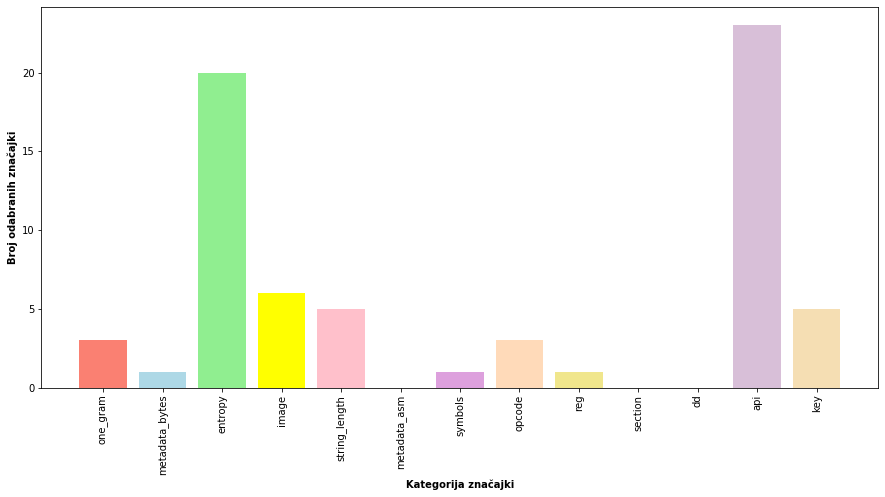

In [251]:
features_type_quantity = { 'one_gram' : 0, 'metadata_bytes' : 0, 'entropy' : 0,
                          'image' : 0, 'string_length' : 0, 'metadata_asm' : 0,
                          'symbols' : 0, 'opcode' : 0, 'reg' : 0, 'section' : 0,
                          'dd' : 0, 'api' : 0, 'key' : 0 }

for i in list(features_univariate.columns.values[:-1][rfecv_rf.get_support()]):
    
    column_index = features.columns.get_loc( i )

    if ( column_index < 258 ) : features_type_quantity['one_gram'] += 1
    elif ( column_index < 260 ) : features_type_quantity['metadata_bytes'] += 1
    elif ( column_index < 462 ) : features_type_quantity['entropy'] += 1
    elif ( column_index < 514 ) : features_type_quantity['image'] += 1
    elif ( column_index < 630 ) : features_type_quantity['string_length'] += 1
    elif ( column_index < 632 ) : features_type_quantity['metadata_asm'] += 1
    elif ( column_index < 639 ) : features_type_quantity['symbols'] += 1
    elif ( column_index < 732 ) : features_type_quantity['opcode'] += 1
    elif ( column_index < 758 ) : features_type_quantity['reg'] += 1
    elif ( column_index < 782 ) : features_type_quantity['section'] += 1
    elif ( column_index < 806 ) : features_type_quantity['dd'] += 1
    elif ( column_index < 1600 ) : features_type_quantity['api'] += 1
    elif ( column_index < 1695 ) : features_type_quantity['key'] += 1
        
        
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(features_type_quantity.keys(), features_type_quantity.values(), color = ['Salmon', 'lightblue', 'lightgreen', 'yellow', 'pink', 'cyan', 'plum', 'peachpuff', 'khaki', 'wheat', 'darkseagreen','thistle','wheat'])
plt.xticks(rotation='vertical')
plt.xlabel('Kategorija značajki', fontweight='bold')
plt.ylabel('Broj odabranih značajki', fontweight='bold')

plt.show()   

In [ ]:
# raspodjela podataka u klase malware-a
features_class_quantity = { }

for i in range(1,10):
    features_class_quantity[i] = classes_begining_and_end_in_features[i][1] - classes_begining_and_end_in_features[i][0]  

classes = list(malware_dict.values())
quantity = list(features_class_quantity.values())
print(features_class_quantity.values())

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(classes, quantity, color = ['Salmon', 'lightblue', 'lightgreen', 'yellow', 'pink', 'cyan', 'plum', 'peachpuff', 'khaki'])
plt.xticks(rotation='vertical')
plt.xlabel('Klase malware-a', fontweight='bold')
plt.ylabel('Količina', fontweight='bold')

plt.show()

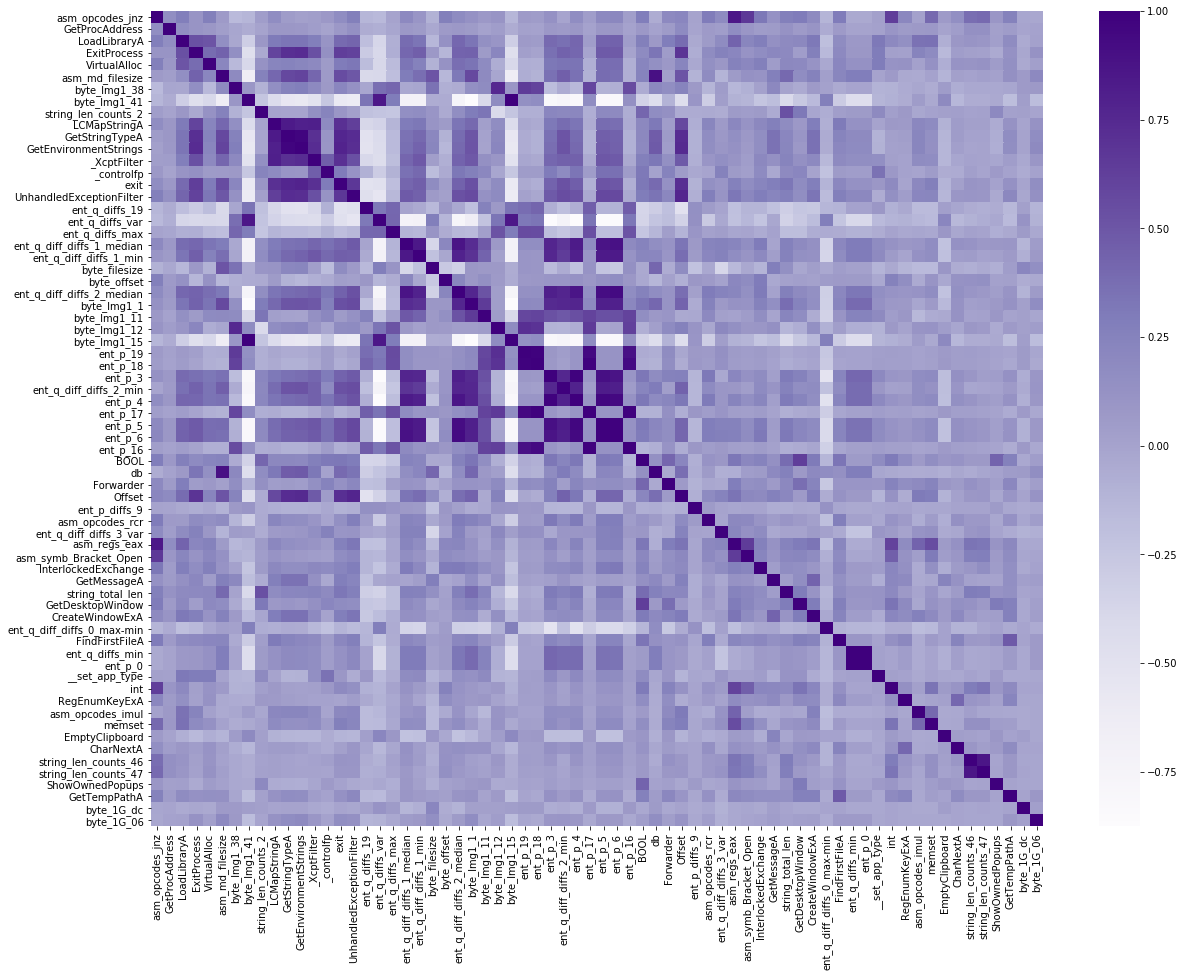

In [186]:
draw_heatmap_anNot(selected_features, selected_features.columns)

In [211]:
scaler = StandardScaler()
X = selected_features
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA() 
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled) 
print("Dimenzije originalnih podataka: %s" % str(X_scaled.shape))
print("Dimenzije projiciranih podataka: %s" % str(X_pca.shape))

Dimenzije originalnih podataka: (10867, 68)
Dimenzije projiciranih podataka: (10867, 68)


In [212]:
selected_features_pca = pd.DataFrame(X_pca, columns=['PC'+str(i) for i in range(1,X_pca.shape[1]+1)])
selected_features_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68
0,0.731239,-1.412382,-2.968726,-0.904368,-0.643469,0.863346,-0.129317,0.329759,0.702227,-0.430494,...,-0.103206,0.091372,0.012509,0.040642,0.031807,0.012390,-0.002101,-0.034829,0.001491,-1.364887e-16
1,1.627098,-1.660767,-2.616941,1.078713,0.207523,2.215366,-0.339605,1.796605,1.748002,-0.286998,...,0.188567,-0.121163,0.007429,0.024963,-0.040983,-0.076109,0.010814,-0.061264,-0.010084,-2.113414e-16
2,2.301394,-1.912829,-2.635854,-0.019069,-0.394653,2.290727,-0.667925,2.285055,2.369445,-0.765878,...,-0.080756,-0.098952,-0.076548,0.024266,0.133809,-0.119116,0.053261,-0.013778,-0.009516,9.072751e-16
3,5.209227,-1.665262,0.707446,9.398950,2.025732,3.235949,-4.068746,-3.346131,0.864773,-1.687267,...,-0.343350,-0.150492,0.262160,-0.288558,-0.497056,0.133542,-0.091156,-0.103968,-0.000762,3.430996e-16
4,-0.361330,-1.393409,-1.204952,0.249313,-1.037846,0.736397,0.221617,-1.115443,1.683220,-1.211751,...,-0.147451,0.189369,-0.019080,-0.013359,-0.090095,-0.029909,-0.005647,-0.000906,-0.005978,8.848205e-17


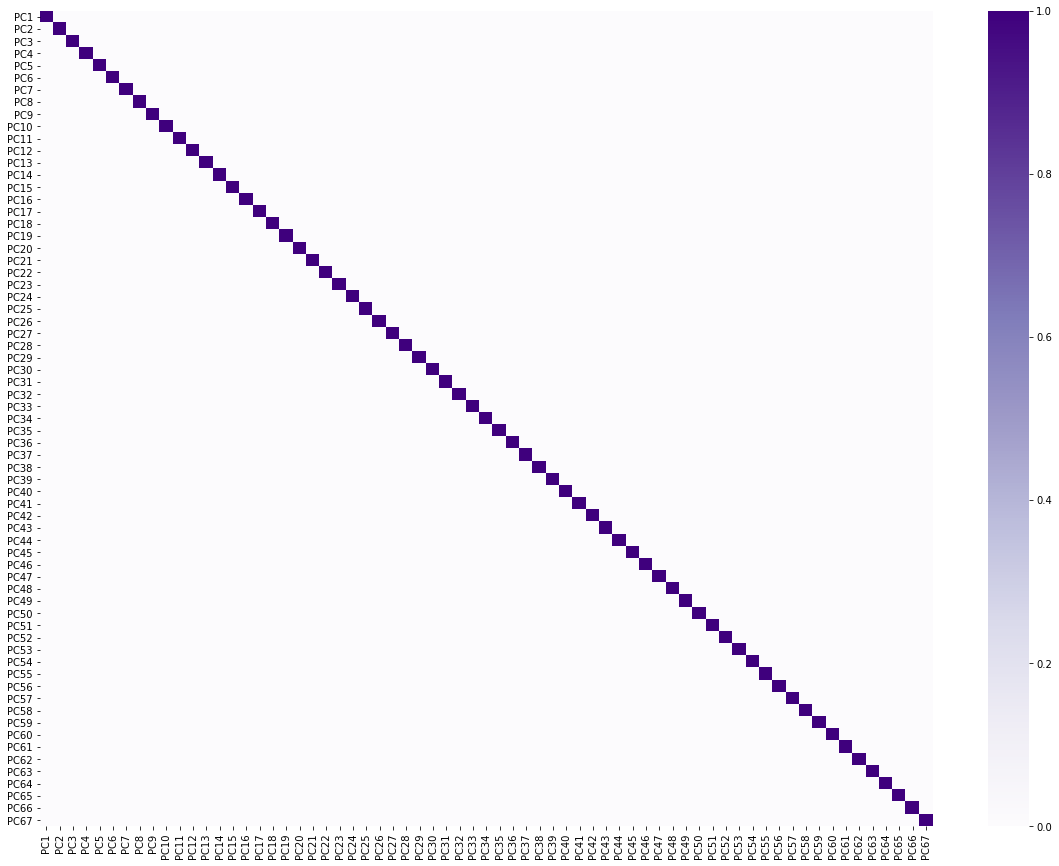

In [213]:
draw_heatmap_anNot(selected_features_pca, selected_features_pca.columns.values[:-1])

[0.23548038 0.32898523 0.40318851 0.4741301  0.51987653 0.554548
 0.58409302 0.61065686 0.63392477 0.65529669 0.67570208 0.69485996
 0.71240562 0.72955605 0.7453745  0.76032477 0.77449913 0.78833172
 0.80188065 0.81475257 0.82688345 0.838841   0.8491143  0.85916219
 0.86885203 0.87766366 0.88614128 0.89435153 0.90242129 0.90964555
 0.91639608 0.92293935 0.9290141  0.93500572 0.94062723 0.94591817
 0.95104531 0.95565505 0.96007553 0.96446125 0.9682     0.97167169
 0.97491368 0.97783781 0.98056227 0.98288988 0.98501557 0.98690278
 0.98875392 0.9904511  0.99191284 0.99319062 0.99434515 0.995437
 0.99643684 0.99718828 0.99788851 0.99841581 0.99885417 0.9992004
 0.99943978 0.99961055 0.99976337 0.99986286 0.99995771 0.99999093
 1.         1.        ]


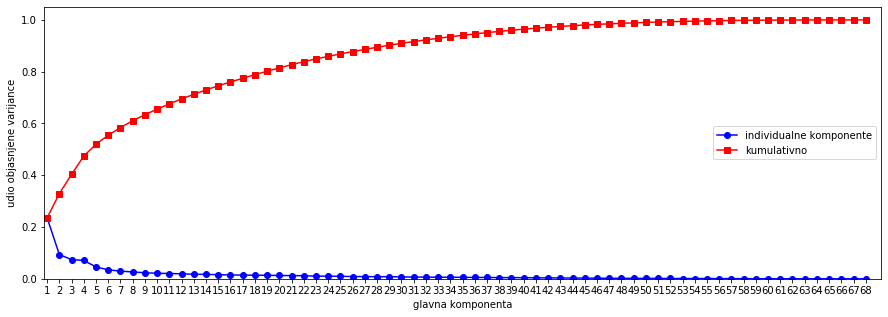

In [218]:
plt.figure(figsize=(15,5))

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cummulative = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,X_pca.shape[1]+1), explained_variance_ratio, '-o', label='individualne komponente', c='b')
plt.plot(range(1,X_pca.shape[1]+1), explained_variance_ratio_cummulative, '-s', label='kumulativno', c='r')

print( explained_variance_ratio_cummulative)
plt.ylabel('udio objasnjene varijance')
plt.xlabel('glavna komponenta')
plt.xlim(0.75,X_pca.shape[1]+1.25)
plt.ylim(0,1.05)
plt.xticks(range(1,X_pca.shape[1]+1))
plt.legend(loc='center right')
plt.show()

In [224]:
final_features = selected_features_pca[list(selected_features_pca.columns.values[:36])]
final_features

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,0.731239,-1.412382,-2.968726,-0.904368,-0.643469,0.863346,-0.129317,0.329759,0.702227,-0.430494,...,0.058948,0.165417,0.236673,-0.037915,0.425161,0.288419,0.007123,-0.514030,-0.030149,-0.379972
1,1.627098,-1.660767,-2.616941,1.078713,0.207523,2.215366,-0.339605,1.796605,1.748002,-0.286998,...,0.686525,-1.366625,-0.337814,-0.417932,-0.409179,-0.500716,1.040292,-1.128256,-0.257818,0.566930
2,2.301394,-1.912829,-2.635854,-0.019069,-0.394653,2.290727,-0.667925,2.285055,2.369445,-0.765878,...,-0.561709,-0.770995,0.030413,-0.138474,0.663894,0.113784,-0.254738,-0.003653,-1.129163,0.156138
3,5.209227,-1.665262,0.707446,9.398950,2.025732,3.235949,-4.068746,-3.346131,0.864773,-1.687267,...,2.653438,-0.226191,-1.498660,-1.218985,0.129957,-0.376460,0.320327,-1.449094,-0.560018,1.168399
4,-0.361330,-1.393409,-1.204952,0.249313,-1.037846,0.736397,0.221617,-1.115443,1.683220,-1.211751,...,-0.606895,0.707186,0.795151,-0.490273,0.763970,0.087777,-0.293358,-0.435186,0.439886,-0.081570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10862,4.365581,2.863267,-3.277183,0.981855,6.500678,-4.916681,2.097705,-0.354700,0.255705,-0.661763,...,0.029838,0.231386,-1.021042,0.306357,0.441486,-0.433697,-0.785720,0.330062,-0.310686,0.328158
10863,2.683881,-0.827743,-3.317393,-0.211248,-0.341357,-0.721589,-0.919754,0.281882,0.368350,1.109990,...,0.771995,1.488786,-0.701361,-0.230467,0.817925,-0.088992,-0.063811,-0.611158,0.976403,0.671637
10864,0.625243,-0.642382,3.290657,1.590244,1.306340,1.963675,-1.352044,-2.546501,-0.738251,-1.400242,...,-0.452011,-0.740713,-0.758349,-2.352449,1.194546,0.853958,0.351698,-0.357595,-0.392441,1.067580
10865,3.766965,1.229693,0.546333,0.669653,1.449160,-0.560781,-3.608745,-1.539472,-0.269002,2.308275,...,1.736215,1.702804,-0.947930,-1.544718,-1.193663,2.175882,0.776841,1.981411,1.548902,0.658128
